# CAD Challenge 1: Binary classification

## Set things up

### Imports

In [1]:
import matplotlib.pyplot as plt

import numpy as np
import os.path
import os

import pickle

import dask
from dask.distributed import Client
import pandas as pd

from sklearn.utils import resample
from sklearn.metrics import precision_score, recall_score, f1_score, roc_curve, roc_auc_score, accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.feature_selection import SelectKBest, f_classif

from skimage import io
from skimage.feature import fisher_vector, learn_gmm, daisy, graycomatrix, graycoprops, local_binary_pattern
from skimage.color import  rgb2hsv,  rgb2lab, rgb2yuv, rgb2gray
from skimage.util import img_as_ubyte, img_as_uint
from skimage.transform import resize

import xgboost as xgb

### Set dataset location

In [2]:
parent_path = os.path.dirname(os.getcwd())

with open(parent_path + '\\dataset_path.txt', 'r') as file:
    dataset_path = file.read().strip()  # Use strip() to remove leading/trailing whitespace

### Set up matplotlib

In [3]:
plt.rcParams['figure.figsize'] = [10, 5]
%matplotlib inline
#%matplotlib widget

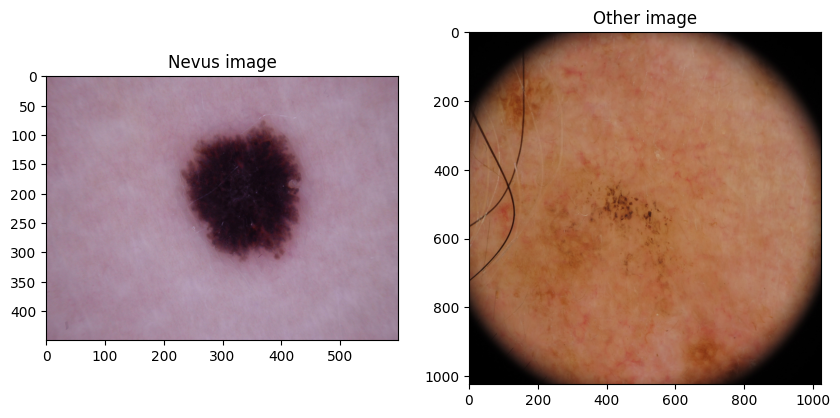

In [4]:
# get the path of the nevus and others images
nevus_path = os.path.join(dataset_path, 'train', 'nevus')
others_path = os.path.join(dataset_path, 'train', 'others')
nevus_val_path = os.path.join(dataset_path, 'val', 'nevus')
others_val_path = os.path.join(dataset_path, 'val', 'others')

# get the filenames of all the images
nevus_filenames = os.listdir(nevus_path)
others_filenames = os.listdir(others_path)
nevus_val_filenames = os.listdir(nevus_val_path)
others_val_filenames = os.listdir(others_val_path)

# load some images for visualization
nevus_image = io.imread(os.path.join(nevus_path, nevus_filenames[0]))
others_image = io.imread(os.path.join(others_path, others_filenames[4]))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.imshow(nevus_image)
ax1.set_title('Nevus image')
ax2.imshow(others_image)
ax2.set_title('Other image')
plt.show()

Nevus image size:  (450, 600, 3)
Nevus image type:  uint8
Nevus image size:  (450, 600)
Nevus image size:  (450, 600)
Nevus image type:  uint16


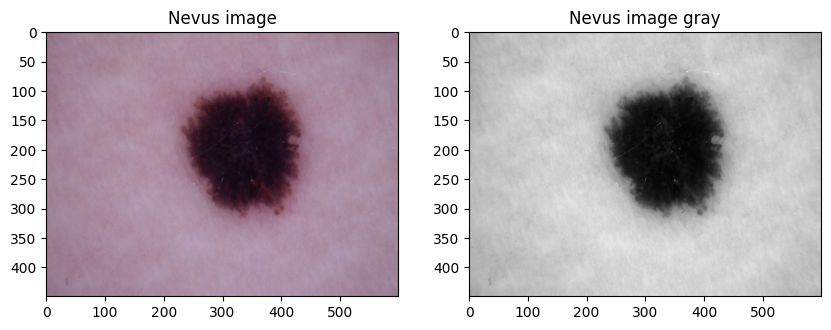

In [5]:
# show size of the image
print('Nevus image size: ', nevus_image.shape)

# show image type
print('Nevus image type: ', nevus_image.dtype)

# convert to grey scale
nevus_image_gray = rgb2gray(nevus_image)

# show size of the image
print('Nevus image size: ', nevus_image_gray.shape)

# convert to uint8
nevus_image_gray = img_as_uint(nevus_image_gray)

# show size of the image
print('Nevus image size: ', nevus_image_gray.shape)

# show image type
print('Nevus image type: ', nevus_image_gray.dtype)

# plot the images
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.imshow(nevus_image)
ax1.set_title('Nevus image')
ax2.imshow(nevus_image_gray, cmap='gray')
ax2.set_title('Nevus image gray')
plt.show()

# Image Descriptors

## Color and texture descriptors

In [6]:
def set_colorspace(img, colorspace='rgb'):

    if colorspace == 'rgb':
        return img
    elif colorspace == 'hsv':
        img = rgb2hsv(img)
        return img
    elif colorspace == 'lab':
        img = rgb2lab(img)
        return img
    elif colorspace == 'yuv':
        img = rgb2yuv(img)
        return img
    else:
        raise Exception('invalid colorspace')


def colorHistogram(img, color_space='rgb', bins=[256,256,256], plot=False):

    if plot:
        colors = ['tab:orange', 'tab:purple', 'tab:cyan']
        fig, ax = plt.subplots(2,3, constrained_layout=True)    
    
    histograms = []

    for ci, c in enumerate(color_space):

        b = bins[ci]
        histogram = np.histogram(img[:,:,ci].flatten(), bins=b)

        if plot:
            ax[0,ci].imshow(img[:,:,ci], cmap='gray')

            ax[1,ci].bar(histogram[1][:-1], histogram[0], width=1,color=colors[ci])
            #add subplot title
            ax[1,ci].set_title(c.upper() + ' channel histogram')

        histograms.append(histogram)


    return histograms

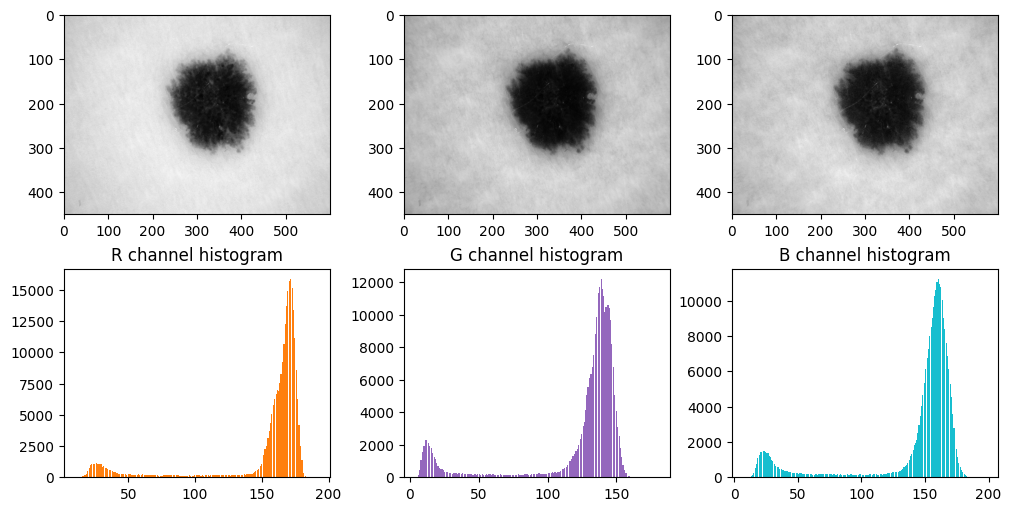

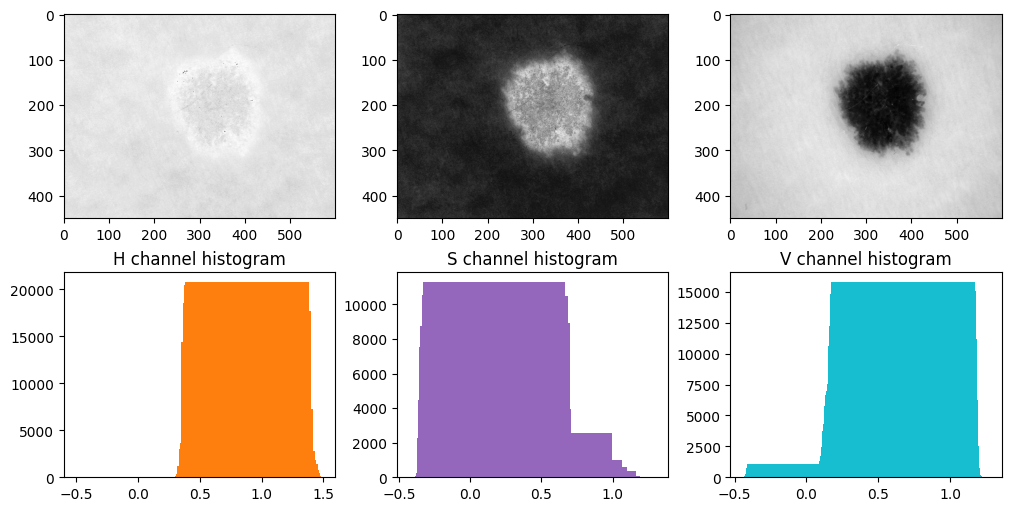

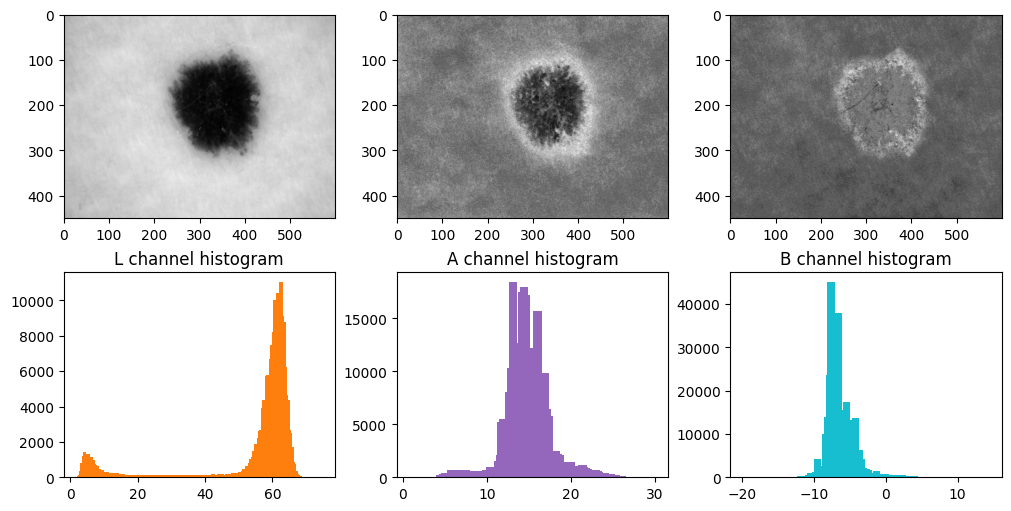

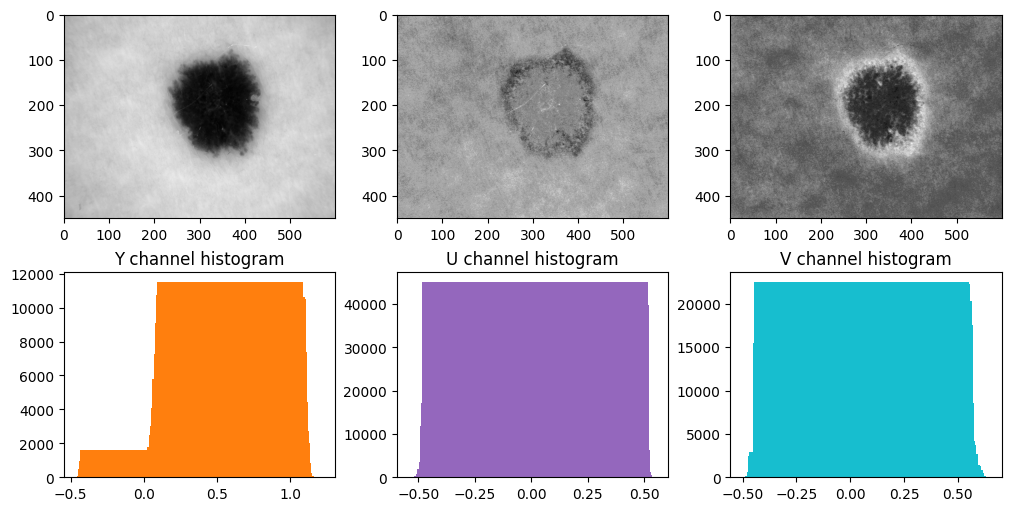

In [7]:
for cs in ['rgb', 'hsv', 'lab', 'yuv']:
    bins = {
    'rgb': [256, 256, 256],
    'hsv': [360, 256, 256],
    'lab': [256, 128, 128],
    'yuv': [256, 128, 128]
    }

    img_cs = set_colorspace(nevus_image, cs)
    h = colorHistogram(img_cs, cs, bins[cs], plot=True)

In [8]:
# check the optimal number of bins for each color space and channel using the Freedman-Diaconis rule

# load sample image
image = io.imread(os.path.join(nevus_path, nevus_filenames[0]))
# image = io.imread(os.path.join(others_path, others_filenames[4]))

cs = ['rgb', 'hsv', 'lab', 'yuv']
bins = {}
for color_space in cs:
    bins_cs = []
    image_cs = set_colorspace(image, color_space)
    for i in range(image.shape[2]):
        bins_cs.append(np.histogram_bin_edges(image_cs[:,:,i], bins='fd').shape[0] - 1)

    bins[color_space] = bins_cs

print(bins)

{'rgb': [450, 378, 384], 'hsv': [955, 494, 458], 'lab': [430, 312, 446], 'yuv': [403, 380, 248]}


In [9]:
# rgb color space represents an image as a 3D array of red, green, and blue channels
# each channel is a 2D array of pixel values ranging from 0 to 255

# hsv color space represents an image as a 3D array of hue, saturation, and value channels
# hue is the color, saturation is the amount of color, and value is the brightness of the color
# For HSV, hue range is [0,179], saturation range is [0,255], and value range is [0,255]. Different software
# use different scales. So if you are comparing OpenCV values with them, you need to normalize these ranges.

# lab color space represents an image as a 3D array of lightness, a, and b channels
# lightness is the brightness of the color, a is the green-red channel, and b is the blue-yellow channel
# L represents darkness to lightness, with values ranging from 0 to 100; a represents greenness to redness
# with values of -128 to +127; and b represents blueness to yellowness also with values from -128 to +127.

# yuv color space represents an image as a 3D array of luminance, u, and v channels
# luminance is the brightness of the color, u is the blue-luminance channel, and v is the red-luminance channel
# Y ranges from 0 to 1 (or 0 to 255 in digital formats), while U and V range from -0.5 to 0.5 (or -128 to 127
# in signed digital form, or 0 to 255 in unsigned form).

In [13]:
color_spaces = ['rgb', 'hsv', 'lab', 'yuv']

# Bin sizes for each color space
# Bins are used to discretize the values of each channel
bins = {
    'rgb': [256, 256, 256],
    'hsv': [360, 256, 256],
    'lab': [256, 128, 128],
    'yuv': [256, 128, 128]
}

@dask.delayed
def extract_features(filename, input_path, output_path, color_spaces, bins):
    img = io.imread(input_path)

    features = {}

    features['filename'] = filename.split('.')[0]

    features['type'] = 'nevus' if 'nev' in filename else 'other'

    features['label'] = 0 if 'nev' in filename else 1


    ## color features

    # create dictionary entries for each color space histogram
    for cs in color_spaces:
        # print(cs)
        img_cs = set_colorspace(img, cs)

        # loop through each channel of the image
        for i in range(image_cs.shape[2]):
             # calculate the histogram for the current channel using np.histogram and the number of bins
            hist_values, _ = np.histogram(img_cs[:,:,i], bins=bins[cs][i], density=False)

            # print(hist_values.shape)
        
            # Loop through each bin and create a key with the channel and bin number
            for j in range(len(hist_values)):
                # Append the histogram value to the dictionary with the key as color_space_channel_bin
                features[cs + "_" + cs[i] + "_" + str(j+1)] = hist_values[j] # Use single value instead of array

    
    ## texture features

    # GLCM parameters and properties
    distances = [1, 2, 3, 4]
    angles = [0, np.pi/4, np.pi/2, 3*np.pi/4] # [0, 45, 90, 135]
    properties = ['dissimilarity', 'correlation', 'contrast', 'homogeneity', 'energy', 'ASM']

    # settings for LBP
    radius = 3
    n_points = 8 * radius

    # convert to grayscale
    img_g = rgb2gray(img)

    # resize image to 600 x 450 dimensions
    img_g = resize(img_g, (600, 450), anti_aliasing=True)

    # convert to integer dtype for LBP
    img_g = img_as_uint(img_g)

    # calculate LBP
    lbp = local_binary_pattern(img_g, n_points, radius, 'uniform')

    # number of bins
    n_bins = int(lbp.max() + 1)

    # calculate histogram
    hist, _ = np.histogram(lbp, density=True, bins=n_bins, range=(0, n_bins))

    # append histogram to list
    for i in range(len(hist)):
        features['lbp_{}'.format(i)] = hist[i]

    # convert to 8-bit
    img_8bit = img_as_ubyte(img_g)

    # calculate GLCM
    glcm = graycomatrix(img_8bit, distances, angles)

    # plt.figure()
    # plt.imshow(glcm[:,:,0,0], cmap='gray')

    for prop in properties:
        res = graycoprops(glcm, prop)

        for i in range(len(distances)):
            for j in range(len(angles)):
                features['glcm_{}_{}_{}'.format(prop, distances[i], int(angles[j]*180/np.pi))] = res[i, j]


    ## save features to pickle file

    # if parent path does not exist, create it
    if not os.path.exists(os.path.dirname(output_path)):
        os.makedirs(os.path.dirname(output_path))

    # save pikle file
    with open(output_path, 'wb') as f:
        pickle.dump(features, f)

    # print(features)

    # return features

In [11]:
# start the dask client for parallel processing

client = Client(n_workers=8, threads_per_worker=2)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 8
Total threads: 16,Total memory: 63.85 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:59446,Workers: 8
Dashboard: http://127.0.0.1:8787/status,Total threads: 16
Started: Just now,Total memory: 63.85 GiB
Comm: tcp://127.0.0.1:59502,Total threads: 2
Dashboard: http://127.0.0.1:59503/status,Memory: 7.98 GiB
Nanny: tcp://127.0.0.1:59449,


In [14]:
# type_path: 'train' or 'val'
# type_tissue: 'nevus' or 'others'
def extract_features_for_filenames(filenames, type_path, type_tissue):
    results = []

    for filename in filenames:

        input_path = os.path.join(dataset_path, type_path, type_tissue, filename)

        output_path = os.path.join(dataset_path, 'features', 'color_and_texture_temp', type_path, type_tissue, filename.split('.')[0] + '.pkl')

        # check if the file already exists
        if os.path.isfile(output_path):
            continue

        result = extract_features(filename, input_path, output_path, color_spaces, bins)
        results.append(result)

    dask.compute(results)


extract_features_for_filenames(nevus_filenames, 'train', 'nevus')
extract_features_for_filenames(others_filenames, 'train', 'others')
extract_features_for_filenames(nevus_val_filenames, 'val', 'nevus')
extract_features_for_filenames(others_val_filenames, 'val', 'others')

client.close()

In [15]:
output_path_color_and_texture = os.path.join(dataset_path, 'features', 'color_and_texture')

if os.path.exists(output_path_color_and_texture) is False:

    # create the folder
    if not os.path.exists(output_path_color_and_texture):
        os.makedirs(output_path_color_and_texture)

    # load all the features from the pickle files

    def load_features(filenames, type_path, type_tissue):
        features = []
        
        for filename in filenames:
            input_file = os.path.join(dataset_path, 'features', type_path, type_tissue, filename.split('.')[0] + '.pkl')

            with open(input_file, 'rb') as f:
                features.append(pickle.load(f))
        
        return features

    nevus_features = load_features(nevus_filenames, 'train', 'nevus')
    others_features = load_features(others_filenames, 'train', 'others')
    nevus_val_features = load_features(nevus_val_filenames, 'val', 'nevus')
    others_val_features = load_features(others_val_filenames, 'val', 'others')

    # create df with all the features
    df_nevus = pd.DataFrame(nevus_features)
    df_others = pd.DataFrame(others_features)
    df_nevus_val = pd.DataFrame(nevus_val_features)
    df_others_val = pd.DataFrame(others_val_features)

    # concatenate the two dataframes
    df_train = pd.concat([df_nevus, df_others], ignore_index=True)
    df_val = pd.concat([df_nevus_val, df_others_val], ignore_index=True)

    # save df to pickle file
    df_train.to_pickle(os.path.join(output_path_color_and_texture, 'df_train.pkl'))
    df_val.to_pickle(os.path.join(output_path_color_and_texture, 'df_val.pkl'))

## Fisher vector features

In [16]:
# start the dask client for parallel processing

client = Client(n_workers=8, threads_per_worker=2)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 8
Total threads: 16,Total memory: 63.85 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:60024,Workers: 8
Dashboard: http://127.0.0.1:8787/status,Total threads: 16
Started: Just now,Total memory: 63.85 GiB
Comm: tcp://127.0.0.1:60065,Total threads: 2
Dashboard: http://127.0.0.1:60067/status,Memory: 7.98 GiB
Nanny: tcp://127.0.0.1:60027,


In [17]:
# try using Fisher vector

@dask.delayed
def extract_daisy_descriptors(filename, input_path):
    img = io.imread(input_path)

    # convert to grayscale
    img = rgb2gray(img)

    # resize image to 600 x 450 dimensions
    img = resize(img, (600, 450), anti_aliasing=True)

    # detector_extractor = SIFT()
    # detector_extractor.detect(exposure.equalize_adapthist(img))
    # detector_extractor.extract(img)
    # # detector_extractor.detect_and_extract(img)
    # return {'filename': filename.split('.')[0], 'orb': detector_extractor.descriptors.astype(np.float32)}

    # descs = daisy(img, step=5, radius=5, rings=1, histograms=8,
    #                      orientations=4)
    # steps 50, radius 15 tried before
    descs = daisy(img, step=40, radius=14, rings=1, histograms=8,
                        orientations=4)
                         
    # transform from 3D to 2D array
    descs = descs.reshape(-1, descs.shape[-1])

    return {'filename': filename.split('.')[0], 'daisy': descs}



# type_path: 'train' or 'val'
# type_tissue: 'nevus' or 'others'
def process_images(filenames, type_path, type_tissue):
    results = []

    for filename in filenames:

        input_path = os.path.join(dataset_path, type_path, type_tissue, filename)

        result = extract_daisy_descriptors(filename, input_path)
        results.append(result)

    gathered = dask.compute(results)

    return gathered

    # if save_batch:
    #     # save pikle file
    #     with open(os.path.join(dataset_path, 'features', 'daisy_descriptors, f'{type_path}_{type_tissue}_daisy_descriptors.pkl', 'wb') as f:
    #         pickle.dump(gathered, f)

        # check if the file already exists

output_path_fv_train = os.path.join(dataset_path, 'features', 'fisher_vectors', 'train_fvs.pkl')
output_path_fv_val = os.path.join(dataset_path, 'features', 'fisher_vectors', 'val_fvs.pkl')

if (os.path.isfile(output_path_fv_train) and os.path.isfile(output_path_fv_val)) is False:
    daisy_descriptors_nevus_train = process_images(nevus_filenames, 'train', 'nevus')
    daisy_descriptors_others_train = process_images(others_filenames, 'train', 'others')
    daisy_descriptors_nevus_val = process_images(nevus_val_filenames, 'val', 'nevus')
    daisy_descriptors_others_val = process_images(others_val_filenames, 'val', 'others')

In [18]:
client.close()

In [19]:
# TODO: try 1D DAISY descriptors
# TODO: test with different radius and step values

In [20]:
if (os.path.isfile(output_path_fv_train) and os.path.isfile(output_path_fv_val)) is False:
    # add the results to a dataframe
    df_daisy_desc_train = pd.DataFrame(daisy_descriptors_nevus_train[0] + daisy_descriptors_others_train[0])
    df_daisy_desc_val = pd.DataFrame(daisy_descriptors_nevus_val[0] + daisy_descriptors_others_val[0])

    # convert to list
    daisy_train = df_daisy_desc_train['daisy'].values.tolist()
    daisy_val = df_daisy_desc_val['daisy'].values.tolist()

In [21]:
if (os.path.isfile(output_path_fv_train) and os.path.isfile(output_path_fv_val)) is False:
    # Train a K-mode GMM
    k = 128
    gmm = learn_gmm(daisy_train, n_modes=k)

In [22]:
if (os.path.isfile(output_path_fv_train) and os.path.isfile(output_path_fv_val)) is False:
    # Compute the Fisher vectors
    fv_train = np.array([
        fisher_vector(descriptor_mat, gmm, improved=True)
        for descriptor_mat in daisy_train
    ])

    fv_val = np.array([
        fisher_vector(descriptor_mat, gmm, improved=True)
        for descriptor_mat in daisy_val
    ])


    # create labels using the sizes of the training and testing sets
    fv_train_labels = np.concatenate((np.zeros(len(daisy_descriptors_nevus_train[0])), np.ones(len(daisy_descriptors_others_train[0]))))
    fv_val_labels = np.concatenate((np.zeros(len(daisy_descriptors_nevus_val[0])), np.ones(len(daisy_descriptors_others_val[0]))))


    # train model
    model = xgb.XGBClassifier(device='cuda', objective='binary:logistic', random_state=42, n_jobs=-1, verbosity=1)
    model.fit(fv_train, fv_train_labels)

In [23]:
if (os.path.isfile(output_path_fv_train) and os.path.isfile(output_path_fv_val)) is False:
    y_pred_proba = model.predict_proba(fv_val)
    y_pred_proba = y_pred_proba[:,1]
    y_pred = y_pred_proba > 0.5

    # classification_report
    print(classification_report(fv_val_labels, y_pred))

    # metrics, show two decimal places
    print('Accuracy:\t{0:.2f}'.format(accuracy_score(fv_val_labels, y_pred)))
    print('Precision:\t{0:.2f}'.format(precision_score(fv_val_labels, y_pred)))
    print('Recall:\t\t{0:.2f}'.format(recall_score(fv_val_labels, y_pred)))
    print('F1 score:\t{0:.2f}'.format(f1_score(fv_val_labels, y_pred)))
    print('AUC score:\t{0:.2f}'.format(roc_auc_score(fv_val_labels, y_pred_proba)))

    # plot the ROC curve
    fpr, tpr, _ = roc_curve(fv_val_labels, y_pred_proba)
    plt.plot(fpr, tpr, linewidth=2, label='ROC curve')
    plt.plot([0,1], [0,1], 'k--', label='Random classifier')
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve')
    plt.legend()
    plt.show()

In [24]:
if (os.path.isfile(output_path_fv_train) and os.path.isfile(output_path_fv_val)) is False:
    # add fisher vectors (np.arrays) to columns in a df using concat with names 'fv_1', 'fv_2', etc.
    df_fv_train = pd.DataFrame(fv_train, columns=['fv_{}'.format(i) for i in range(fv_train.shape[1])])
    df_fv_val = pd.DataFrame(fv_val, columns=['fv_{}'.format(i) for i in range(fv_val.shape[1])])

    # if parent path does not exist, create it
    if not os.path.exists(os.path.dirname(output_path_fv_train)):
        os.makedirs(os.path.dirname(output_path_fv_train))

    # save the dataframes to pickle files
    df_fv_train.to_pickle(os.path.join(dataset_path, 'features', 'fisher_vectors', 'fv_train.pkl'))
    df_fv_val.to_pickle(os.path.join(dataset_path, 'features', 'fisher_vectors', 'fv_val.pkl'))

## Load features

In [25]:
# load color and texture features
df_train = pd.read_pickle(os.path.join(dataset_path, 'features', 'color_and_texture', 'df_train.pkl'))
df_val = pd.read_pickle(os.path.join(dataset_path, 'features', 'color_and_texture', 'df_val.pkl'))

# load the fisher vector features
df_fv_train = pd.read_pickle(os.path.join(dataset_path, 'features', 'fisher_vectors', 'train_fvs.pkl'))
df_fv_val = pd.read_pickle(os.path.join(dataset_path, 'features', 'fisher_vectors', 'val_fvs.pkl'))

# add fisher vectors to the dataframe
df_train = pd.concat([df_train, df_fv_train], axis=1)
df_val = pd.concat([df_val, df_fv_val], axis=1)

# Classification

In [26]:
# get 500 of each
# df_feat_s = pd.concat([resample(df[df['label'] == 1], n_samples=2500, random_state=42),
#                      resample(df[df['label'] == 0], n_samples=2500, random_state=42)], ignore_index=True)

df_train_s = df_train

# store the labels
y_train = df_train_s['label']
y_val = df_val['label']

columns_to_drop =  ['filename', 'type', 'label']

# keep only HSV features
for cs in ['rgb', 'lab', 'yuv', 'fv_']:
    columns_to_drop.extend([col for col in df_train_s.columns if cs in col])


# drop filename and label columns
df_train_s_d = df_train_s.drop(columns_to_drop, axis=1)
df_val_d = df_val.drop(columns_to_drop, axis=1)


# assign to new variables for clarity
X_train = df_train_s_d
X_val = df_val_d

print(X_train.shape)
print(X_val.shape)

(15195, 994)
(3796, 994)


In [27]:
# standard scale for PCA
sd_scaler = StandardScaler()
X_train_scaled = sd_scaler.fit_transform(X_train)
X_val_scaled = sd_scaler.transform(X_val)

# # apply PCA
# pca = PCA(n_components=.999, random_state=42)
# X_train_scaled_pca = pca.fit_transform(X_train_scaled)
# X_val_scaled_pca = pca.transform(X_val_scaled)

# # min-max normalization
# mm_scaler = MinMaxScaler()
# X_train_scaled_pca_norm = mm_scaler.fit_transform(X_train_scaled_pca)
# X_val_scaled_pca_norm = mm_scaler.transform(X_val_scaled_pca)

# # recover columns names
# X_train_scaled_pca_norm = pd.DataFrame(X_train_scaled_pca_norm, columns=pca.get_feature_names_out(), index=X_train.index)
# X_val_scaled_pca_norm = pd.DataFrame(X_val_scaled_pca_norm, columns=pca.get_feature_names_out(), index=X_val.index)

# print(X_train_scaled_pca_norm.shape)
# print(X_val_scaled_pca_norm.shape)

In [28]:
# train model

xgb_m = xgb.XGBClassifier(device='cuda', objective='binary:logistic', random_state=42, n_jobs=-1, verbosity=1)
xgb_m.fit(X_train_scaled, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device='cuda', early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=-1,
              num_parallel_tree=None, random_state=42, ...)

In [29]:
# feature selection

# select features using ANOVA F-value test
f_selector = SelectKBest(f_classif, k=100)
X_train_scaled_f = f_selector.fit_transform(X_train_scaled, y_train)
X_val_scaled_f = f_selector.transform(X_val_scaled)

# train model
xgb_m_f = xgb.XGBClassifier(device='cuda', objective='binary:logistic', random_state=42, n_jobs=-1, verbosity=1)
xgb_m_f.fit(X_train_scaled_f, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device='cuda', early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=-1,
              num_parallel_tree=None, random_state=42, ...)

In [30]:
# train RF model

rf_m = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_m.fit(X_train_scaled, y_train)

RandomForestClassifier(n_jobs=-1, random_state=42)

In [31]:
# train voting classifier

voting_m = VotingClassifier(estimators=[('xgb', xgb_m), ('rf', rf_m)], voting='soft', n_jobs=-1)
voting_m.fit(X_train_scaled, y_train)

VotingClassifier(estimators=[('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None,
                                            device='cuda',
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_...None, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=None,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=None, n_jobs=-1,
                                            num_parallel_tree=None,
                                            random_state=42, ...)),
                             ('rf',
                              RandomForestClassifier(n_jobs=-1,
                                                     random_state=42))],
                 n_jobs=-1, voting='soft')

c:\Users\legor\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\core.py:160: UserWarning: [21:23:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0cec3277c4d9d0165-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


              precision    recall  f1-score   support

           0       0.84      0.83      0.83      1931
           1       0.83      0.83      0.83      1865

    accuracy                           0.83      3796
   macro avg       0.83      0.83      0.83      3796
weighted avg       0.83      0.83      0.83      3796

Accuracy:  0.8327186512118019
Precision:  0.8271276595744681
Recall:  0.8337801608579088
F1 score:  0.8304405874499332
AUC score:  0.9064219597563667


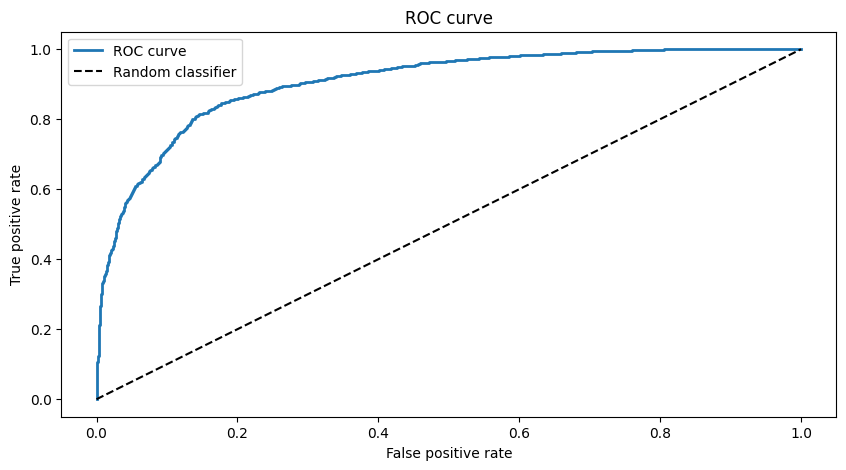

In [32]:
# model_c = svm_m
model_c = voting_m

y_val_pred_proba = model_c.predict_proba(X_val_scaled)
y_val_pred_proba = y_val_pred_proba[:,1]
y_val_pred = y_val_pred_proba > 0.5


# classification_report
print(classification_report(y_val, y_val_pred))

# metrics
print('Accuracy: ', accuracy_score(y_val, y_val_pred))
print('Precision: ', precision_score(y_val, y_val_pred))
print('Recall: ', recall_score(y_val, y_val_pred))
print('F1 score: ', f1_score(y_val, y_val_pred))
print('AUC score: ', roc_auc_score(y_val, y_val_pred_proba))

# plot the ROC curve
fpr, tpr, _ = roc_curve(y_val, y_val_pred_proba)
plt.plot(fpr, tpr, linewidth=2, label='ROC curve')
plt.plot([0,1], [0,1], 'k--', label='Random classifier')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend()
plt.show()

In [33]:
# todo: try ensemble method, 3 classifier with voting for each type of feature
# consider the diff of size of the features
# don't need to use thte full dataset
# resize images during texture feature extraction